# API REST : accéder à des données et des fonctionnalités via le web


Gabriel Couture, Félix-Antoine Fortin, Olivier Chouinard-Banville

In [7]:
import io
from pprint import pprint

import requests

import pydicom
import matplotlib.pyplot as plt
from pydicom import uid
from pydicom.filebase import DicomFileLike
from matplotlib.image import imread


def read_dicom_dataset(raw_data: bytes) -> pydicom.Dataset:
    """Permet de lire les bytes d'un fichier DICOM et le transformer en Dataset DICOM"""
    instance_uid = uid.generate_uid()
    buffer = io.BytesIO(raw_data)
    ds = pydicom.dcmread(buffer)

    return ds


def dicom_dataset_to_bytes(ds: pydicom.Dataset) -> io.BytesIO:
    """Permet d'écrire un Dataset DICOM en bytes"""
    buffer = io.BytesIO()
    memory_dataset = DicomFileLike(buffer)
    pydicom.dcmwrite(memory_dataset, ds)
    memory_dataset.seek(0)

    return buffer


def show_image_from_bytes(raw_data: bytes) -> None:
    buffer = io.BytesIO(raw_data)
    img = imread(buffer, format='png')

    plt.figure(figsize=(16, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


URL = 'https://progfest-rest.apps.valeria.science'

## Mise en situation

- Vous êtes un stagiaire en physique médiale
- Vous devez évaluer la qualité de traitements de radiothérapie
- Pour ce faire : nous utilisons les histogrammes dose-volume (DVH)

---

## Radiothérapie : cours express
Plusieurs étapes sont nécessaires afin d'administrer un traitement de radiothérapie.
Lorsque qu'une tumeur est identifiée et qu'un traitement de radiothérapie est prescrit,
il faut d'abord 1) faire l'acquisition d'image de la région de la tumeur, 2)
tracer des contours afin de construire une structure en trois dimensions de la zone à
irradier et des organes sensibles, 3) faire une planification de traitement, c'est-à-dire
comment et où la dose sera délivrée (typiquement fait par un logiciel de planification de traitement), 4)
valider le traitement qui vient d'être planifié.

<br>
<center><img src="./imgs/flot-radiotherapie.png" style="width: 700px;"></center>
<br>
<center><img src="./imgs/radiotherapy.png" style="width: 400px;"></center>


#### Acquisition d'images (ex. CT)
Il est d'abord nécessaire de faire l'acquisition d'images de la régions à traiter.

<br>
<center><img src="./imgs/phantom-thorax.png" style="width: 300px;"></center>


#### Tracé de structure (organes/région d'intérêt)
Une fois que les images obtenues, un radio-oncologue vient tracer des contours sur (presque) toutes les images.
Les tracés, une fois recombinées, forme une structure en 3D.

<br>
<table border="0">
 <tr>
    <td><img src="./imgs/contours.png" style="height: 250px;"></td>
    <td><img src="./imgs/structure.png" style="height: 250px;"></td>
 </tr>
</table>

    
#### Planification de la dose
Vient ensuite la planification de la dose à délivrer. Celle-ci est fait grâce à un logiciel de planification
de traitement. Le résultat est une grille de dose (une matrice en 3D, où chaque point est une valeur de dose en Gray, unité de mesure de la dose absorbée).
On voit ici une tranche de la matrice de dose superposée à un contour.

<br>
<center><img src="./imgs/dose-distribution.png" style="height: 200px;"></center>

#### Données impliquées
Le processus créée plusieurs fichiers, tous sous le format __DICOM__.
Le format DICOM est un format spécialisé utilisé en physique médicale et en imagerie médicale.

Voici une représentation du contenu dans 3 de ces fichiers DICOM :
- Images CT
    - Fichier DICOM de type "__CT__"
- Structure (région/organe dessiné)
    - Fichier DICOM de type "__RTStruct__"
- Carte de dose (array en 3D de la dose délivrée)
    - Fichier DICOM de type "__RTDose__"

<br>
<center><img src="./imgs/ct-struct-dose.gif" style="width: 100%;"></center>


## Comment évaluer la qualité du traitement?

Évaluer la qualité d'un traitement de radiothérapie est un aspect fondammental du domaine.
Pour ce faire, les histogrammes dose-volume (__DVH__) sont utilisés.

Il est possible de construire un DVH avec les fichiers DICOM RTStruct et RTDose. 
En effet, il suffit d'abord de superposer la matrice de dose planifiée aux structures.
Par cette superposition, il est possible de prendre les point de la matrice de dose qui entre dans
les structures, et d'en faire un histogramme, comme montré ci-dessous.
<br>

<center><img src="./imgs/dvh-process.png" style="height: 300px;"></center>
<center><img src="./imgs/dvh-diff-to-cumulative.png" style="height: 250px;"></center>

## Résultat final : un DVH!

Voici un exemple de DVH. On peut voir quelles structures ont reçu le plus de dose.
On voit que la structure _cible_ (la tumeur) a reçue, sur plus de 100% de son volume, au moins 51 Gy,
qui correspond à la dose prescripte. On voit aussi que les structure sensibles, soit les
poumons, ont reçu moins de dose. 

Un bon traitement de radiothérapie irradie 100% du volume de la tumeur avec au moins la dose de prescription, et épargne le plus possible les structures sensibles.

<br>
<center><img src="./imgs/dvh-exemple.png" style="width: 550px;"></center>

---

# Atelier : ce qui est à faire

- L'objectif de l'atelier est de vous permettre de comprendre comment utiliser une API REST.

    
- À cet fin, une API REST vous est mise à disposition
    - Elle expose des données au format DICOM, des fonctions de calcul de DVH et plus!


- Voici ce que vous devrez faire
    - Toutes ces étapes seront faites avec des requêtes HTTP avec la librairie Python `requests`.
<center><img src="./imgs/atelier.png" style="width: 1200px;"></center>

## Données à manipuler

- 3 fichiers DICOM RTStruct (un cylindre, une sphère et un cone)
- 1 fichier DICOM RTDose (la matrice en 3D des valeurs de dose)
<table border="0">
 <tr>
    <td><img src="./imgs/cylinder.png" style="height: 250px;"></td>
    <td><img src="./imgs/sphere.png" style="height: 250px;"></td>
    <td><img src="./imgs/cone.png" style="height: 250px;"></td>
    <td><img src="./imgs/dose-workflow.png" style="height: 250px;"></td>
 </tr>
</table>
Source : https://doi.org/10.1118/1.4923175

---

# Informations utiles
### Librairie Python `requests`
 
```python
# GET
response = requests.get(url='http://<url>/<route>', params={'key': 'value'})

# POST
response = requests.post(
    url='http://<url>/<route>',
    data={'key': 'value'},          # Pour les valeurs (str, float ou int)
    files={'key': file_bytes},      # Pour des fichiers (sous forme de bytes)
    json={'key': {'key': 'value'}}) # Pour des dictionnaires ou listes

# PUT
response = requests.put(
    url='http://<url>/<route>',
    data={'key': 'value'},           # ...
    files={'key': file_bytes},       # ...
    json={'key': {'key': 'value'}})  # ...

# DELETE
response = requests.delete(url='http://<url>/<route>', params={'key': 'value'})
```

## Valider la connexion

- Validez d'abord que vous pouvez interagir avec l'API REST.

In [8]:
response = requests.get(f'{URL}')
print(response.status_code)
pprint(response.json())

200
{'message': "Bonjour et bienvenue à l'atelier sur les API REST!"}


## 1. Création d'un compte
- Pour créer un compte, soumetter votre IDUL via un POST à l'adresse `http://<url>/account`.
    - Dans le cadre de cet atelier, vous n'aurez pas besoin de mot de passe.
    - Vous pouvez soumettre votre idul de cette façon : 
        ```python
        response = resquests.post(
            url='http://<url>/account',
            data={'idul': 'votre-idul'}
        )
        ```
- Regardez le code HTTP (`response.status_code`) ainsi que le message (`response.text` ou `response.json()`).

In [9]:
response = requests.post(f'{URL}/account', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

201
{'message': 'created'}


## 2. Authentification

- Génial, vous avez maintenant un compte!
- Ce n'est pas n'importe qui qui peut accéder des données médicales. Pour pouvoir les récupérer, vous devez être identifié.
- Pour l'identification, il est commun que les API REST utilisent un jeton, ou `token` en anglais.

- Pour récupérer un token (donc s'identifier), faites un POST à l'adresse `http://<url>/auth`, tout en fournissant votre IDUL, comme à la création du compte.
- Observez la réponse, votre `token` devrait s'y trouver!

In [10]:
response = requests.post(f'{URL}/auth', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

TOKEN = response.json()['token']

200
{'token': 'e2a2f3d81a0de2ba37bb821c9e16c7960e21cf84'}


## 3. Récupération des données

- Vous avez maintenant votre `token` pour vous authentifier, il est désormais possible de récupérer les données.
- L'adresse où les données sont accessibles est `http://<url>/data`.
- Faites un GET, avec votre token en paramètre (`params={'token': '<votre-token>'}`) pour vérifier quelles données sont accessibles.

In [11]:
response = requests.get(f'{URL}/data', params={'token': TOKEN})
print(response.json())

['sphere', 'cylinder', 'cone', 'dose']


- Vous devriez observer 4 noms de donnée. Chacune d'entre elles correspond à un fichier DICOM de structure (RTStruct), ou de dose (RTDose).
- Pour les récupérer, faites un GET à `http://<url>/data/<nom-donnée>`, toujours en ayant votre token en paramètre.
- Remarquez que le contenu de la réponse est un fichier binaire (`response.content`).
    - On ne peut évidemment pas le lire en tant que texte ou JSON. Une fonction vous est fournie pour lire ce contenu et le transformer en `Dataset` (format pour manipuler des fichiers DICOM) : 
        - `dataset = read_dicom_dataset(response.content)`


- Récupérer les 4 fichiers DICOM, et transformez les tous en `Dataset`.

In [12]:
response = requests.get(f'{URL}/data/sphere', params={'token': TOKEN})
sphere = read_dicom_dataset(response.content)

response = requests.get(f'{URL}/data/cylinder', params={'token': TOKEN})
cylinder = read_dicom_dataset(response.content)

response = requests.get(f'{URL}/data/cone', params={'token': TOKEN})
cone = read_dicom_dataset(response.content)

response = requests.get(f'{URL}/data/dose', params={'token': TOKEN})
dose = read_dicom_dataset(response.content)

- Maintenant que vous avez les 4 `Dataset`, vérifiez s'ils contiennent des informations personnelles.
    - Observez l'attribut `dataset.PatientName` pour voir s'il contient un nom personnel.

In [13]:
print(sphere.PatientName)
print(cylinder.PatientName)
print(cone.PatientName)
print(dose.PatientName)

Gabriel Couture
Gabriel Couture
Gabriel Couture
Gabriel Couture


## 4. Anonymisation des données
- En santé, il est important de manipuler des données anonymes lors des activités de recherche.
- Il est donc nécessaire d'anonymiser vos données.
- Pour anonymisé un `Dataset`
    1. Transformez le en `bytes` avec la fonction `dataset_bytes = dicom_dataset_to_bytes(dataset)`
    2. Faire un POST à `http://<url>/anonymize` avec le dataset en bytes en tant que fichier
        - `requests.post(..., files={'file': dataset_bytes})`
    3. Récupérer la réponse et transformez la en dataset (`dataset = read_dicom_dataset(response.content)`)
    
    
- Faites cet exercise pour vos 4 `Dataset`

In [14]:
sphere_bytes = dicom_dataset_to_bytes(sphere)
response = requests.post(f'{URL}/anonymize', files={'file': sphere_bytes})
sphere = read_dicom_dataset(response.content)

cylinder_bytes = dicom_dataset_to_bytes(cylinder)
response = requests.post(f'{URL}/anonymize', files={'file': cylinder_bytes})
cylinder = read_dicom_dataset(response.content)

cone_bytes = dicom_dataset_to_bytes(cone)
response = requests.post(f'{URL}/anonymize', files={'file': cone_bytes})
cone = read_dicom_dataset(response.content)

dose_bytes = dicom_dataset_to_bytes(dose)
response = requests.post(f'{URL}/anonymize', files={'file': dose_bytes})
dose = read_dicom_dataset(response.content)

- Vérifiez si les `Dataset` ont toujours de l'informations personnelles (`dataset.PatientName`).

In [15]:
print(sphere.PatientName)
print(cylinder.PatientName)
print(cone.PatientName)
print(dose.PatientName)

^
^
^
^


## 5. Calculer des DVH

- Maintenant que vous avez des données anonymes, vous pouvez obtenir les DVH.
- Pour chaque structure :
    1. Transformez les datasets de structure et de dose en `bytes` avec la fonction `dicom_dataset_to_bytes`
    2. Faites un POST à `http://<url>/dvh`, les dataset en bytes en tant que fichiers `files={'file_struct': struct_bytes, 'file_dose': dose_bytes}`
    3. Récupérez les réponses sous le format JSON (`response.json()`).

In [16]:
dvhs = []

for struct in [sphere, cylinder, cone]:
    response = requests.post(
        f'{URL}/dvh',
        files={
            'file_struct': dicom_dataset_to_bytes(struct),
            'file_dose': dicom_dataset_to_bytes(dose)
        }
    )
    dvhs.append(response.json())

## 6. Tracer des DVH

- Maintenant que vous avez les données des DVH, vous pouvez tracer un graphique.
- Pour ce faire, faites un POST à `http://<url>/dvh/plot`.
- Le post doit contenir les informations suivantes :
```python
requests.post(
    ...,
    json={
        'dvhs': [
            {'name': ..., 'volumes': ..., 'doses': ..., 'volume_units': ..., 'dose_units': ...},
            {'name': ..., 'volumes': ..., 'doses': ..., 'volume_units': ..., 'dose_units': ...}
            ...
        ]
    }
)
```

In [17]:
response = requests.post(
    f'{URL}/dvh/plot',
    json={'dvhs': dvhs}
)
print(response.status_code)

200


- Le contenu de la réponse est une image `.png` des DVH. Vous pouvez l'afficher avec la fonction `show_image_from_bytes(response.content)`. 

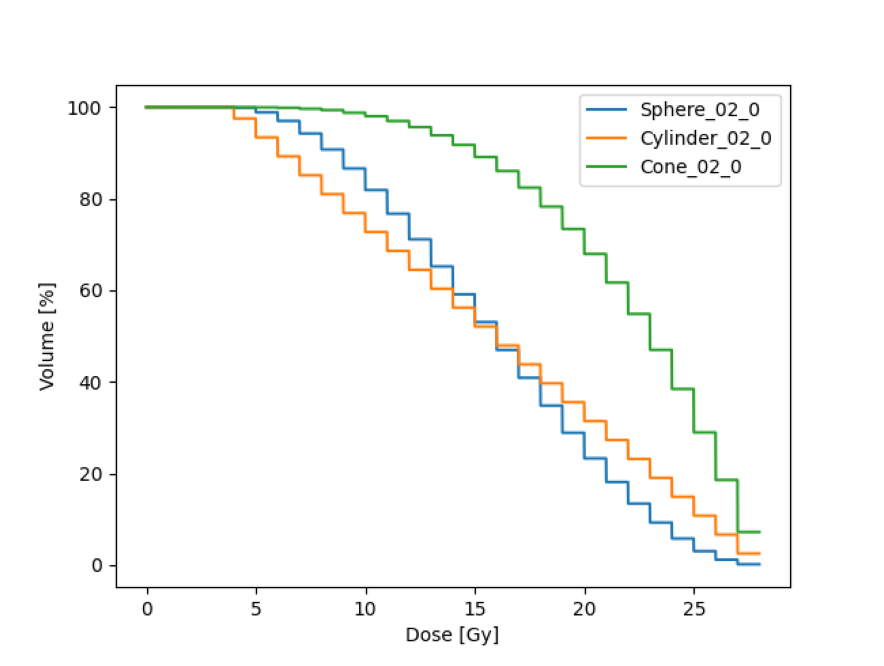

In [18]:
show_image_from_bytes(response.content)

## Félicitations, vous avez obtenu des DVH!

- Maintenant que vous savez manipuler une API REST, vous pouvez allez voir comment en faire une. 
    - La librairie utilisée pour construire l'API REST utilisée dans cet atelier est celle-ci https://flask-restful.readthedocs.io/en/latest/quickstart.html.
    - L'API REST utilisée dans cet atelier se trouve ici : https://github.com/ulaval-rs/prog-fest-web-workshop/blob/main/app.py.
